# Northern Gulf of Alaska (NGA) Watershed


In [1]:
watershed = 'NorthernGulfofAlaska'

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import copy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# some_file.py
#import sys
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions')
#import Abnormal_data_values_control 
#from Abnormal_data_values_control import threC
import os
os.getcwd()
os.getcwd().rsplit('/',1)[0]

'/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/17-NGA'

In [3]:
def nan_groupby(df, method = 'mean', ratio = 0.1): # 0.1*24=2.4 allow 2 hourly missing data points within 24h (one day)
    groupby_df = pd.DataFrame(columns = df.columns)
    for col in df.columns: 
        df_col = df[[col]]
        for group, data in df_col.groupby(df_col.index.date):
            na_rows = data.shape[0] - data.count()[0]
            total_rows = data.shape[0]
            na_ratio = na_rows/total_rows
            if method == 'mean':
                if 0<na_ratio<ratio: # don't want to waste data in this case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean().values[0]
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", data.mean().values[0])
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean(skipna = False).values[0]     
            if method == 'sum':
                if 0<na_ratio<ratio: # don't want to waste data case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = (data.sum().values[0])/(1-na_ratio) # standardize the value
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", (data.sum().values[0])/(1-na_ratio))
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.sum(skipna = False).values[0]                
    return groupby_df

# function for aggregation(daily) and combination
def aggre_and_comb_daily(lst, axis=1, func = "sum"):
    prep = pd.DataFrame()
    for df in lst:
        if axis == 1:
            if func == "sum":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')
            elif func == "mean":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')        
        elif axis == 0: # concatenate by year
            if func == "sum":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            elif func == "mean":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            prep.index.rename('DateTime', inplace = True)
        prep = prep[prep.index.notnull()]
    print('The final table is:')
    display(prep.head(2))
    display(prep.tail(2))
    prep.index = pd.to_datetime(prep.index,errors = 'coerce')
    return prep

# a case-by-case function where the threshold values could be changed according with different watersheds
def threC(prep,varname):
# This function returns a dataframe without unrealistic values
# This function only deletes unrealistic data, doesn't deal with the outliers
# SR avg is 1361 W/m2 for earth, could be net solar radiation so include negative values  
    thre_dic = {'Discharge':(0,9999999),  # comment here is the threshold values are changed for this case
                'Precipitation':(0,999), 
                'AirTemperature':(-20,50),
                'SolarRadiation':(-50,400),
                'RelativeHumidity': (0,100), 
                'WindDirection': (0,365),
                'WindSpeed': (0, 99),
                'SWE': (0,9999),
                'SnowDepth': (0,9999),
                'VaporPressure': (0,101), 
                'SoilMoisture': (0,100),
                'SoilTemperature': (-50,50), 
                'Isotope': (-9999,9999), 
                'DewPointTemperature': (-100,100), 
                'Snowmelt': (0,9999)
                 }
    thmin = thre_dic[varname][0]
    thmax = thre_dic[varname][1]    
    for i in range(len(prep.columns)):
        col = prep.columns[i]     
        # tranfer the values to be numeric 
        prep[col] = np.array(pd.to_numeric(prep[col], errors='coerce'))        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) < thmin)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0]!=0:     
            print(col,'Out of lower threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)))
            print(col,'Out of lower threshold number:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0])        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) > thmax)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) >thmax)).shape[0]!=0:
            print(col,'Out of upper threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)))
            print(col,'Out of upper threshold number:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)).shape[0])            
    return prep

### Streamflow

In [4]:
# streamflow
# Jarvis Creek
# Dwnstr (Downstream)
data13 = pd.read_csv('https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3A42c260ae-dda9-44df-a8dc-d534c23ab8ba',
                    sep=" ",header = 0,parse_dates = True,
                   infer_datetime_format = True)

data13.set_index(['Date','Time_AST'],inplace = True)
data13 = threC(data13,'Discharge')
data13.head()

Discharge_cms
Date       Time_AST               
2013-05-22 09:15:00            0.9
           09:30:00            0.9
           09:45:00            0.9
           10:00:00            0.9
           10:15:00            0.9

In [5]:
data14 = pd.read_csv('https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3A006a6037-ac93-434a-9068-0588dda43232',
                    sep=" ",header = 0,parse_dates = True,
                   infer_datetime_format = True)
data14.set_index(['Date','Time_AST'],inplace = True)
data14 = threC(data14,'Discharge')
data14.head()

Discharge_cms
Date       Time_AST               
2014-05-08 17:00:00            5.8
           17:15:00            5.8
           17:30:00            5.8
           17:45:00            5.8
           18:00:00            5.8

In [6]:
data15 = pd.read_csv('https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3A8f187f89-44eb-49e6-b67a-f00298241a96',
                    sep=" ",header = 0,parse_dates = True,
                   infer_datetime_format = True)
data15.set_index(['Date','Time_AST'],inplace = True)
data15 = threC(data15,'Discharge')
data15.head()

Discharge_cms
Date       Time_AST               
2015-04-29 08:47:00           1.31
           09:02:00           0.72
           09:17:00           0.00
           09:32:00           0.08
           09:47:00           0.16

In [7]:
data16 = pd.read_csv('https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3Aac8be32e-3265-44ae-b825-7de71d7e587d',
                    sep=" ",header = 0,parse_dates = True,
                   infer_datetime_format = True)
data16.set_index(['Date','Time_AST'],inplace = True)
data16 = threC(data16,'Discharge')
data16.head()

Discharge_cms
Date       Time_AST               
2016-04-26 18:15:00           1.61
           18:30:00           1.61
           18:45:00           1.63
           19:00:00           1.61
           19:15:00           1.61

In [8]:
data13.index = pd.to_datetime(data13.index.get_level_values(0))
data14.index = pd.to_datetime(data14.index.get_level_values(0))
data15.index = pd.to_datetime(data15.index.get_level_values(0))
data16.index = pd.to_datetime(data16.index.get_level_values(0))
data_dwnstr=aggre_and_comb_daily([data13,data14,data15,data16], axis=0, func = "mean")
data_dwnstr.columns = ['Dwnstr_Discharge']

['Discharge_cms', datetime.date(2016, 5, 5)]
nan ratio is 0.08333333333333333 , groupby value is 0.736931818181818
['Discharge_cms', datetime.date(2016, 5, 6)]
nan ratio is 0.052083333333333336 , groupby value is 0.5651648351648353
The final table is:


Discharge_cms
DateTime                
2013-05-22       1.22203
2013-05-23       1.66354

Discharge_cms
DateTime                
2016-10-17       1.73042
2016-10-18       1.81102

In [9]:
data15 = pd.read_csv('https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3A1d03eac9-8585-4d15-8250-46e5819b1695',
                    sep=" ",header = 0,parse_dates = True,
                   infer_datetime_format = True)
#data15.astype('str')
data15.set_index(['Date','Time_AST'],inplace = True)
data15 = threC(data15,'Discharge')
data15.head()

Discharge_cms
Date       Time_AST               
2015-06-15 21:15:00          11.09
           21:30:00          10.54
           21:45:00          10.98
           22:00:00          11.11
           22:15:00          11.01

In [10]:
data16 = pd.read_csv('https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3Aed6a669c-2bc9-4379-82aa-d0a27a7f9ae4',
                    sep=" ",header = 0,parse_dates = True,
                   infer_datetime_format = True)
#data16.astype('str')
data16.set_index(['Date','Time_AST'],inplace = True)
data16 = threC(data16,'Discharge')
data16.head()

Discharge_cms
Date       Time_AST               
2016-05-01 21:30:00           5.09
           21:45:00           5.09
           22:00:00           5.07
           22:15:00           5.04
           22:30:00           4.96

In [11]:
data15.index = pd.to_datetime(data15.index.get_level_values(0))
data16.index = pd.to_datetime(data16.index.get_level_values(0))
data_upstr=aggre_and_comb_daily([data15,data16], axis=0, func = "mean")
data_upstr.columns = ['Upstr_Discharge']

The final table is:


Discharge_cms
DateTime                
2015-06-15       11.0627
2015-06-16       10.1586

Discharge_cms
DateTime                
2016-10-05       8.75417
2016-10-06          8.01

In [12]:
prep = aggre_and_comb_daily([data_dwnstr,data_upstr],axis = 1, func = "mean")

The final table is:


Dwnstr_Discharge Upstr_Discharge
2013-05-22          1.22203             NaN
2013-05-23          1.66354             NaN

Dwnstr_Discharge Upstr_Discharge
2016-10-17          1.73042             NaN
2016-10-18          1.81102             NaN

Dwnstr_Discharge
Upstr_Discharge


Dwnstr_Discharge  Upstr_Discharge
2013-05-22       1222.033898              NaN
2013-05-23       1663.541667              NaN
2013-05-24       2881.250000              NaN
2013-05-25       5454.166667              NaN
2013-05-26       7700.000000              NaN

<Figure size 720x288 with 0 Axes>

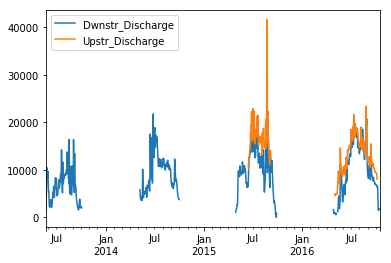

In [13]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]*1000 # 
                       
df = threC(df,'Discharge')
Discharge = copy.deepcopy(df)
Discharge.plot()
Discharge.head()

### Hydrometeorology

In [14]:
# extract data
data12 = pd.read_csv('https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3A3694183f-67c5-4e88-86ce-067c23714547',
                    header = 0,parse_dates = True,skiprows = 47,
                   infer_datetime_format = True)
data12.set_index(['Date','Time_UTC'],inplace = True)
data12.head()

avgAT_C_1m  avgAT_C_2m  avgRH_1m  avgRH_2m  avgDP_C  \
Date       Time_UTC                                                        
2012-09-26 14:00:00        8.03        7.43     40.63     41.58    -4.54   
           15:00:00        6.80        6.50     43.18     43.69    -4.83   
           16:00:00        5.65        5.72     47.01     46.36    -4.69   
           17:00:00        5.75        5.84     47.18     46.51    -4.70   
           18:00:00        4.73        5.10     47.66     46.14    -5.42   

                     sampleWD_Deg  sampleWS_m.s  maxWS_m.s  
Date       Time_UTC                                         
2012-09-26 14:00:00         191.7          9.86      12.01  
           15:00:00         178.3          5.03      11.58  
           16:00:00         171.9          2.23       7.07  
           17:00:00         197.0          2.27       4.45  
           18:00:00         190.1          0.00       2.61

In [15]:
data13 = pd.read_csv('https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3A29163773-b1d3-4da8-942a-d6879fab5eb5',
                    header = 0,parse_dates = True,skiprows = 47,
                   infer_datetime_format = True)
#data13.astype('str')
data13.set_index(['Date','Time_UTC'],inplace = True)
data13.head()

avgAT_C_1m  avgAT_C_2m  avgRH_1m  avgRH_2m  avgDP_C  \
Date       Time_UTC                                                        
2013-01-01 00:00:00       -0.99       -0.80     49.57     48.21   -10.17   
           01:00:00       -1.07       -0.85     47.73     46.00   -10.69   
           02:00:00       -0.69       -0.44     46.10     44.48   -10.91   
           03:00:00       -0.16        0.07     44.27     42.60   -10.88   
           04:00:00       -0.67       -0.46     48.54     46.95   -10.14   

                     totalPPT_mm.hr  sampleSnowDepth_m  sampleWD_Deg  \
Date       Time_UTC                                                    
2013-01-01 00:00:00             0.0             6999.0         39.96   
           01:00:00          7777.0             6999.0         22.46   
           02:00:00             0.0             6999.0         34.61   
           03:00:00             0.0             6999.0         37.36   
           04:00:00             0.0             6999.0         54.37   

                     sampleWS_m.s  maxWS_m.s  
Date       Time_UTC                           
2013-01-01 00:00:00         13.03      14.68  
           01:00:00          8.83      14.15  
           02:00:00         12.30      13.15  
           03:00:00          9.35      13.56  
           04:00:00          8.55      15.30

In [16]:
data14 = pd.read_csv('https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3A7e4ff6fc-60a1-46f7-913f-08ad7e525282',
                    header = 0,parse_dates = True,skiprows = 47,
                   infer_datetime_format = True)
#data14.astype('str')
data14.set_index(['Date','Time_UTC'],inplace = True)
data14.head()

avgAT_C_1m  avgAT_C_2m  avgRH_1m  avgRH_2m  avgDP_C  \
Date       Time_UTC                                                        
2014-01-01 00:00:00       -0.55       -0.27     57.30     54.89    -7.90   
           01:00:00       -0.57       -0.22     54.11     51.39    -8.44   
           02:00:00       -0.93       -0.41     55.53     53.09    -8.82   
           03:00:00       -0.76       -0.34     61.75     59.00    -7.61   
           04:00:00       -0.71       -0.42     69.12     67.25    -5.35   

                     totalPPT_mm.hr  sampleSnowDepth_m  sampleWD_Deg  \
Date       Time_UTC                                                    
2014-01-01 00:00:00             0.0              0.020         85.30   
           01:00:00             0.0              0.025        347.20   
           02:00:00             0.0              0.020         51.77   
           03:00:00             0.0              0.022         57.27   
           04:00:00             0.0              0.021         66.61   

                     sampleWS_m.s  maxWS_m.s  avgSolarRad_W.m2  
Date       Time_UTC                                             
2014-01-01 00:00:00          6.30      10.71            6999.0  
           01:00:00          2.43       8.17            6999.0  
           02:00:00          0.39       2.41            6999.0  
           03:00:00          7.39       9.98            6999.0  
           04:00:00          9.27       9.56            6999.0

In [17]:
data15 = pd.read_csv('https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3Af710745e-d748-4a43-bf7f-6c5d8be8724d',
                    header = 0,parse_dates = True,skiprows = 47,
                   infer_datetime_format = True)
#data15.astype('str')
data15.set_index(['Date','Time_UTC'],inplace = True)
data15.head()

avgAT_C_1m  avgAT_C_2m  avgRH_1m  avgRH_2m  avgDP_C  \
Date       Time_UTC                                                        
2015-01-01 00:00:00       -4.31       -4.15     93.20     91.80    -5.24   
           01:00:00       -4.67       -4.56     92.65     91.40    -5.67   
           02:00:00       -4.84       -4.74     92.40     91.15    -5.89   
           03:00:00       -5.03       -4.94     92.15     90.95    -6.10   
           04:00:00       -5.33       -5.23     91.75     90.65    -6.46   

                     totalPPT_mm.hr  sampleSnowDepth_m  sampleWD_Deg  \
Date       Time_UTC                                                    
2015-01-01 00:00:00          7777.0              0.077         178.1   
           01:00:00          7777.0              0.071         184.1   
           02:00:00          7777.0              0.072         195.5   
           03:00:00          7777.0              0.081         217.5   
           04:00:00          7777.0              0.099         179.8   

                     sampleWS_m.s  maxWS_m.s  avgSolarRad_W.m2  
Date       Time_UTC                                             
2015-01-01 00:00:00          1.66       2.24            6999.0  
           01:00:00          1.36       1.79            6999.0  
           02:00:00          0.82       1.90            6999.0  
           03:00:00          0.51       1.26            6999.0  
           04:00:00          1.18       1.38            6999.0

In [18]:
data16 = pd.read_csv('https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3A31005cd2-b921-4335-a4cc-9098a5acb669',
                    header = 0,parse_dates = True,skiprows = 47,
                   infer_datetime_format = True)
#data16.astype('str')
data16.set_index(['Date','Time_UTC'],inplace = True)
data16.head()

avgAT_C_1m  avgAT_C_2m  avgRH_1m  avgRH_2m  avgDP_C  \
Date       Time_UTC                                                        
2016-01-01 00:00:00       -2.79       -2.59     62.40     60.74    -8.93   
           01:00:00       -2.84       -2.66     66.65     64.17    -8.33   
           02:00:00       -2.48       -2.28     61.72     60.30    -8.89   
           03:00:00       -2.35       -2.15     58.56     59.07    -9.38   
           04:00:00       -2.47       -2.26     57.68     59.48    -9.70   

                     totalPPT_mm.hr  sampleSnowDepth_m  sampleWD_Deg  \
Date       Time_UTC                                                    
2016-01-01 00:00:00          7777.0              0.088         25.12   
           01:00:00          7777.0              0.087         54.04   
           02:00:00          7777.0              0.091         37.12   
           03:00:00          7777.0              0.092         44.40   
           04:00:00          7777.0              0.090         53.46   

                     sampleWS_m.s  maxWS_m.s avgSolarRad_W.m2  
Date       Time_UTC                                            
2016-01-01 00:00:00         14.96      20.79              NAN  
           01:00:00         13.18      17.89              NAN  
           02:00:00         15.16      17.38              NAN  
           03:00:00         15.42      19.52              NAN  
           04:00:00         13.67      18.10              NAN

In [19]:
data_met = pd.concat([data12,data13,data14,data15,data16],axis = 0,sort = False)
data_met.head()

avgAT_C_1m  avgAT_C_2m  avgRH_1m  avgRH_2m  avgDP_C  \
Date       Time_UTC                                                        
2012-09-26 14:00:00        8.03        7.43     40.63     41.58    -4.54   
           15:00:00        6.80        6.50     43.18     43.69    -4.83   
           16:00:00        5.65        5.72     47.01     46.36    -4.69   
           17:00:00        5.75        5.84     47.18     46.51    -4.70   
           18:00:00        4.73        5.10     47.66     46.14    -5.42   

                     sampleWD_Deg  sampleWS_m.s  maxWS_m.s  totalPPT_mm.hr  \
Date       Time_UTC                                                          
2012-09-26 14:00:00         191.7          9.86      12.01             NaN   
           15:00:00         178.3          5.03      11.58             NaN   
           16:00:00         171.9          2.23       7.07             NaN   
           17:00:00         197.0          2.27       4.45             NaN   
           18:00:00         190.1          0.00       2.61             NaN   

                     sampleSnowDepth_m avgSolarRad_W.m2  
Date       Time_UTC                                      
2012-09-26 14:00:00                NaN              NaN  
           15:00:00                NaN              NaN  
           16:00:00                NaN              NaN  
           17:00:00                NaN              NaN  
           18:00:00                NaN              NaN

In [20]:
# 1. Precipitation
prep = data_met[['totalPPT_mm.hr']]
prep.head()

totalPPT_mm.hr
Date       Time_UTC                
2012-09-26 14:00:00             NaN
           15:00:00             NaN
           16:00:00             NaN
           17:00:00             NaN
           18:00:00             NaN

In [21]:
prep = threC(prep,'Precipitation')

In [22]:
prep.index = prep.index.get_level_values(0)
prep.index = pd.to_datetime(prep.index)
prep = prep.groupby(prep.index.date).sum()
prep.columns = ['CMR_Precipitation']

CMR_Precipitation


CMR_Precipitation
2012-09-26                0.0
2012-09-27                0.0

<Figure size 720x288 with 0 Axes>

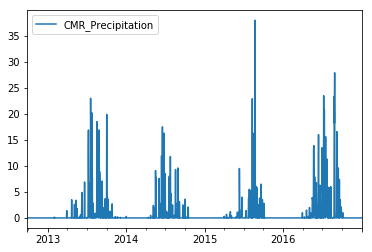

In [23]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 

df = threC(df,'Precipitation')
Precipitation = copy.deepcopy(df)
Precipitation.plot()
Precipitation.head(2)

In [24]:
# 2. AirTemperature
prep = data_met[['avgAT_C_1m','avgAT_C_2m']]
prep.head()

avgAT_C_1m  avgAT_C_2m
Date       Time_UTC                        
2012-09-26 14:00:00        8.03        7.43
           15:00:00        6.80        6.50
           16:00:00        5.65        5.72
           17:00:00        5.75        5.84
           18:00:00        4.73        5.10

In [25]:
prep = threC(prep,'AirTemperature')

In [26]:
prep.index = prep.index.get_level_values(0)
prep.index = pd.to_datetime(prep.index)
prep = threC(prep,'AirTemperature')
prep = prep.groupby(prep.index.date).mean()
prep.columns = ['CMR_AirTemperature_1m','CMR_AirTemperature_2m']

CMR_AirTemperature_1m
CMR_AirTemperature_2m


CMR_AirTemperature_1m  CMR_AirTemperature_2m
2012-09-26                 4.4020                4.79900
2012-09-27                 3.7025                3.80625

<Figure size 720x288 with 0 Axes>

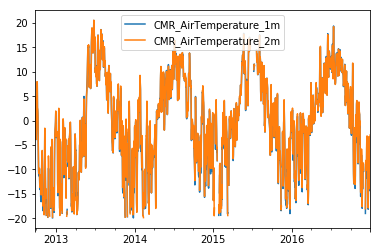

In [27]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
AirTemperature = copy.deepcopy(df)
AirTemperature.plot()
AirTemperature.head(2)

In [28]:
# 3. SolarRadiation
prep = data_met[['avgSolarRad_W.m2']]
prep = threC(prep,'SolarRadiation')
prep.tail()

avgSolarRad_W.m2
Date       Time_UTC                  
2016-12-31 19:00:00               0.0
           20:00:00               0.0
           21:00:00               0.0
           22:00:00               0.0
           23:00:00               0.0

CMR_SolarRadiation


CMR_SolarRadiation
2012-09-26                 NaN
2012-09-27                 NaN

<Figure size 720x288 with 0 Axes>

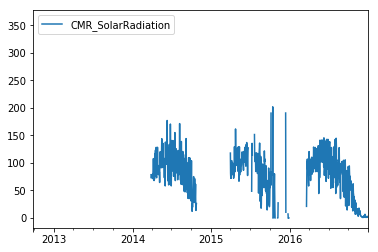

In [29]:
prep.index = prep.index.get_level_values(0)
prep.index = pd.to_datetime(prep.index)
prep.columns = ['CMR_SolarRadiation']
prep = pd.DataFrame(pd.to_numeric(prep['CMR_SolarRadiation'],errors = 'coerce'))

prep = threC(prep,'SolarRadiation')
prep = prep.groupby(prep.index.date).mean()

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
SolarRadiation= copy.deepcopy(df)
SolarRadiation.plot()
SolarRadiation.head(2)

In [30]:
# 4. RelativeHumidity
# Jarvis
prep = data_met[['avgRH_1m','avgRH_2m']]
prep = threC(prep,'RelativeHumidity')
prep.head()

avgRH_1m  avgRH_2m
Date       Time_UTC                    
2012-09-26 14:00:00     40.63     41.58
           15:00:00     43.18     43.69
           16:00:00     47.01     46.36
           17:00:00     47.18     46.51
           18:00:00     47.66     46.14

CMR_RelativeHumidity_1m
CMR_RelativeHumidity_2m


CMR_RelativeHumidity_1m  CMR_RelativeHumidity_2m
2012-09-26                 47.24600                45.355000
2012-09-27                 54.34875                53.600833

<Figure size 720x288 with 0 Axes>

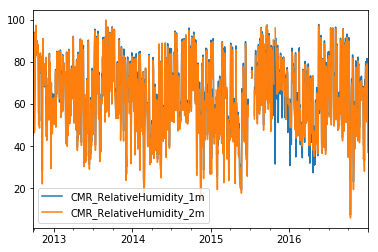

In [31]:
prep.index = prep.index.get_level_values(0)
prep.index = pd.to_datetime(prep.index)
prep.columns = ['CMR_RelativeHumidity_1m','CMR_RelativeHumidity_2m']
#prep = pd.DataFrame(pd.to_numeric(prep['CMR_SolarRadiation'],errors = 'coerce'))

prep = threC(prep,'RelativeHumidity')
prep = prep.groupby(prep.index.date).mean()

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
RelativeHumidity = copy.deepcopy(df)
RelativeHumidity.plot()
RelativeHumidity.head(2)

In [32]:
# 5. WindDirection
data_met.head()
prep = data_met[['sampleWD_Deg']]
prep = threC(prep,'WindDirection')
prep.head()

sampleWD_Deg
Date       Time_UTC              
2012-09-26 14:00:00         191.7
           15:00:00         178.3
           16:00:00         171.9
           17:00:00         197.0
           18:00:00         190.1

CMR_WindDirection


CMR_WindDirection
2012-09-26         188.730000
2012-09-27         187.329167

<Figure size 720x288 with 0 Axes>

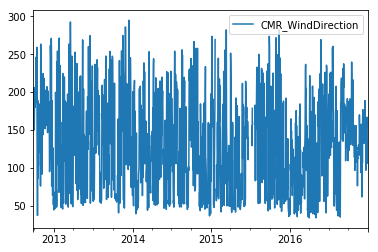

In [33]:
prep.index = prep.index.get_level_values(0)
prep.index = pd.to_datetime(prep.index)
prep.columns = ['CMR_WindDirection']
#prep = pd.DataFrame(pd.to_numeric(prep['CMR_SolarRadiation'],errors = 'coerce'))

prep = threC(prep,'WindDirection')
prep = prep.groupby(prep.index.date).mean()
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))   ## change
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
WindDirection = copy.deepcopy(df)
WindDirection.plot()
WindDirection.head(2)

In [34]:
# 6. WindSpeed
data_met.head()
prep = data_met[['sampleWS_m.s']]
prep = threC(prep,'WindSpeed')
prep.head()

sampleWS_m.s
Date       Time_UTC              
2012-09-26 14:00:00          9.86
           15:00:00          5.03
           16:00:00          2.23
           17:00:00          2.27
           18:00:00          0.00

CMR_WindSpeed


CMR_WindSpeed
2012-09-26          2.531
2012-09-27         10.130

<Figure size 720x288 with 0 Axes>

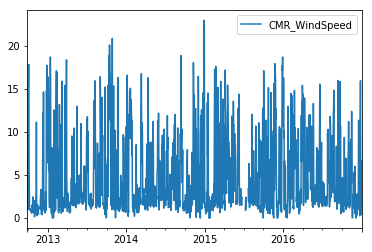

In [35]:
prep.index = prep.index.get_level_values(0)
prep.index = pd.to_datetime(prep.index)
prep.columns = ['CMR_WindSpeed']
#prep = pd.DataFrame(pd.to_numeric(prep['CMR_SolarRadiation'],errors = 'coerce'))

prep = threC(prep,'WindSpeed')
prep = prep.groupby(prep.index.date).mean()

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))   ## change
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
WindSpeed = copy.deepcopy(df)
WindSpeed.plot()
WindSpeed.head(2)

In [36]:
path =  os.getcwd().rsplit('/',1)[0]+'/RawData/'

In [37]:
# 7. SWE
data= pd.read_csv(path +'JarvisWatershedSnow_2011_2016.txt',
                    sep=" ",header = 0,parse_dates = True,
                   infer_datetime_format = True)
#data13.astype('str')
#data.set_index(['Date','Time_AST'],inplace = True)
#data = data[[]]
data.head()


SITE        Date  Avg..Density..g.cm.3.or.kg.m.3.  \
0                     S2  2011-03-29                              0.2   
1                     S1  2011-03-30                              0.2   
2  NW of coal mine ridge  2011-03-29                              0.1   
3   W of coal mine ridge  2011-03-29                              0.1   
4                    S20  2011-03-29                              0.2   

   Avg..Depth..m.  SWE..snow.water.eqvivalent..mm.  
0             0.4                             77.9  
1             0.3                             59.4  
2             0.3                             26.6  
3             0.1                             17.9  
4             0.3                             68.5

In [38]:
data['Date'].unique()

array(['2011-03-29', '2011-03-30', '2012-03-27', '2012-03-28',
       '2013-04-03', '2013-04-04', '2013-04-05', '2013-04-19',
       '2014-03-25', '2014-03-27', '2014-03-28', '2014-03-26',
       '2015-03-31', '2015-04-01', '2015-04-02', '2016-04-01',
       '2016-04-20', '2016-03-22', '2016-03-23', '2016-03-21'],
      dtype=object)

In [39]:
# 8.SnowDepth
data_met.head()
prep = data_met[['sampleSnowDepth_m']]
prep = threC(prep,'SnowDepth')
prep.head()

sampleSnowDepth_m
Date       Time_UTC                   
2012-09-26 14:00:00                NaN
           15:00:00                NaN
           16:00:00                NaN
           17:00:00                NaN
           18:00:00                NaN

CMR_SnowDepth


CMR_SnowDepth
2012-09-26            NaN
2012-09-27            NaN

<Figure size 720x288 with 0 Axes>

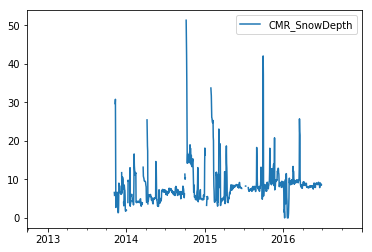

In [40]:
prep.index = prep.index.get_level_values(0)
prep.index = pd.to_datetime(prep.index)
prep.columns = ['CMR_SnowDepth']
#prep = pd.DataFrame(pd.to_numeric(prep['CMR_SolarRadiation'],errors = 'coerce'))


prep = prep.groupby(prep.index.date).mean()

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))    ## change
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]*100 # 
df = threC(df,'SnowDepth')                    
SnowDepth = copy.deepcopy(df)
SnowDepth.plot()
SnowDepth.head(2)

In [41]:
# 9. SnowMelt

In [42]:
# 10. VaporPressure (DewPoint for this site)
prep = data_met[['avgDP_C']]
prep = threC(prep,'VaporPressure')
prep.head()

avgDP_C
Date       Time_UTC         
2012-09-26 14:00:00      NaN
           15:00:00      NaN
           16:00:00      NaN
           17:00:00      NaN
           18:00:00      NaN

CMR_DewPoint


CMR_DewPoint
2012-09-26           NaN
2012-09-27           NaN

<Figure size 720x288 with 0 Axes>

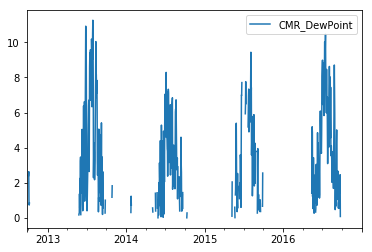

In [43]:
prep.index = prep.index.get_level_values(0)
prep.index = pd.to_datetime(prep.index)
prep.columns = ['CMR_DewPoint']
#prep = pd.DataFrame(pd.to_numeric(prep['CMR_SolarRadiation'],errors = 'coerce'))

prep = threC(prep,'DewPointTemperature')
prep = prep.groupby(prep.index.date).mean()

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))    ## change
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] # 
                       
DewPoint = copy.deepcopy(df)
DewPoint.plot()
DewPoint.head(2)

In [44]:
# 11. SoilMoisture
data12 = pd.read_csv('https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3A04d20ae4-6e83-4ac1-9227-eae228b83cc4',
                    header = 0,parse_dates = True,skiprows = 27,
                   infer_datetime_format = True)
#data.astype('str')
data12.set_index(['Date','Time_UTC'],inplace = True)
data12.head()

SM_VWC_10cm  SM_VWC_20cm  SM_VWC_40cm
Date       Time_UTC                                       
2012-09-26 14:00:00     7777.000     7777.000      7777.00
           15:00:00        0.223        0.209         0.16
           16:00:00        0.223        0.209         0.16
           17:00:00        0.223        0.209         0.16
           18:00:00        0.223        0.209         0.16

In [45]:
data13 = pd.read_csv('https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3A82e818ed-e894-4c1e-b614-8c5a2099034d',
                    header = 0,parse_dates = True,skiprows = 27,
                   infer_datetime_format = True)
#data.astype('str')
data13.set_index(['Date','Time_UTC'],inplace = True)
data13.head()

SM_VWC_10cm  SM_VWC_20cm  SM_VWC_40cm
Date       Time_UTC                                       
2013-01-01 00:00:00         0.05        0.053        0.039
           01:00:00         0.05        0.053        0.039
           02:00:00         0.05        0.053        0.039
           03:00:00         0.05        0.053        0.039
           04:00:00         0.05        0.053        0.039

In [46]:
data14 = pd.read_csv('https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3A198c0aa4-edce-4278-b1aa-60eae2ec9e1d',
                    header = 0,parse_dates = True,skiprows = 27,
                   infer_datetime_format = True)
#data.astype('str')
data14.set_index(['Date','Time_UTC'],inplace = True)
data14.head()

SM_VWC_10cm  SM_VWC_20cm  SM_VWC_40cm
Date       Time_UTC                                       
2014-01-01 00:00:00        0.046         0.05        0.039
           01:00:00        0.047         0.05        0.039
           02:00:00        0.047         0.05        0.039
           03:00:00        0.047         0.05        0.039
           04:00:00        0.047         0.05        0.039

In [47]:
data15 = pd.read_csv('https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3Aaeb6c74a-aa11-4fe0-bf40-adcb5bfcd4b8',
                    header = 0,parse_dates = True,skiprows = 27,
                   infer_datetime_format = True)
#data.astype('str')
data15.set_index(['Date','Time_UTC'],inplace = True)
data15.head()

SM_VWC_10cm  SM_VWC_20cm  SM_VWC_40cm
Date       Time_UTC                                       
2015-01-01 00:00:00        0.056        0.051        0.043
           01:00:00        0.056        0.051        0.043
           02:00:00        0.056        0.051        0.043
           03:00:00        0.056        0.051        0.043
           04:00:00        0.056        0.051        0.043

In [48]:
data16 = pd.read_csv('https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3Adde87f00-b540-4880-8260-bb38d40d4ad0',
                    header = 0,parse_dates = True,skiprows = 27,
                   infer_datetime_format = True)
#data.astype('str')
data16.set_index(['Date','Time_UTC'],inplace = True)
data16.head()

SM_VWC_10cm  SM_VWC_20cm  SM_VWC_40cm
Date       Time_UTC                                       
2016-01-01 00:00:00        0.044        0.049        0.041
           01:00:00        0.044        0.049        0.041
           02:00:00        0.044        0.049        0.041
           03:00:00        0.044        0.049        0.041
           04:00:00        0.044        0.049        0.041

In [49]:
data12 = threC(data12,'SoilMoisture')
data13 = threC(data13,'SoilMoisture')
data14 = threC(data14,'SoilMoisture')
data15 = threC(data15,'SoilMoisture')
data16 = threC(data16,'SoilMoisture')
data12.index = pd.to_datetime(data12.index.get_level_values(0))
data13.index = pd.to_datetime(data13.index.get_level_values(0))
data14.index = pd.to_datetime(data14.index.get_level_values(0))
data15.index = pd.to_datetime(data15.index.get_level_values(0))
data16.index = pd.to_datetime(data16.index.get_level_values(0))
prep=aggre_and_comb_daily([data12,data13,data14,data15,data16], axis=0, func = "mean")
prep.columns = ['CMR_SoilMoisture_10cm','CMR_SoilMoisture_20cm','CMR_SoilMoisture_40cm']
prep.head()

['SM_VWC_10cm', datetime.date(2012, 10, 22)]
nan ratio is 0.041666666666666664 , groupby value is 0.19813043478260872
['SM_VWC_20cm', datetime.date(2012, 10, 22)]
nan ratio is 0.041666666666666664 , groupby value is 0.1849565217391305
['SM_VWC_40cm', datetime.date(2012, 10, 22)]
nan ratio is 0.041666666666666664 , groupby value is 0.13765217391304346
['SM_VWC_10cm', datetime.date(2013, 8, 24)]
nan ratio is 0.041666666666666664 , groupby value is 0.24986956521739134
['SM_VWC_10cm', datetime.date(2013, 8, 26)]
nan ratio is 0.08333333333333333 , groupby value is 0.2419090909090909
['SM_VWC_10cm', datetime.date(2013, 10, 31)]
nan ratio is 0.041666666666666664 , groupby value is 0.19473913043478258
['SM_VWC_10cm', datetime.date(2013, 11, 1)]
nan ratio is 0.041666666666666664 , groupby value is 0.19465217391304346
['SM_VWC_20cm', datetime.date(2013, 8, 24)]
nan ratio is 0.041666666666666664 , groupby value is 0.24660869565217397
['SM_VWC_20cm', datetime.date(2013, 8, 26)]
nan ratio is 0.0833

SM_VWC_10cm SM_VWC_20cm SM_VWC_40cm
DateTime                                      
2012-09-26         NaN         NaN         NaN
2012-09-27    0.222667    0.207917    0.160125

SM_VWC_10cm SM_VWC_20cm SM_VWC_40cm
DateTime                                      
2016-12-30       0.038   0.0470417       0.043
2016-12-31       0.038   0.0472917       0.043

CMR_SoilMoisture_10cm CMR_SoilMoisture_20cm CMR_SoilMoisture_40cm
DateTime                                                                    
2012-09-26                   NaN                   NaN                   NaN
2012-09-27              0.222667              0.207917              0.160125
2012-09-28                 0.221                0.2065              0.158667
2012-09-29              0.219625              0.205417              0.157375
2012-09-30                0.2185              0.204167              0.156042

CMR_SoilMoisture_10cm
CMR_SoilMoisture_20cm
CMR_SoilMoisture_40cm


CMR_SoilMoisture_10cm  CMR_SoilMoisture_20cm  \
2012-09-26                    NaN                    NaN   
2012-09-27              22.266667              20.791667   

            CMR_SoilMoisture_40cm  
2012-09-26                    NaN  
2012-09-27                16.0125

<Figure size 720x288 with 0 Axes>

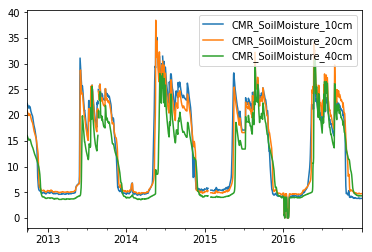

In [50]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))    ## change
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]*100 #                     

df = threC(df,'SoilMoisture')            
SoilMoisture = copy.deepcopy(df)
SoilMoisture.plot()
SoilMoisture.head(2)

In [51]:
# 11. Isotope

In [52]:
# 12. SoilTemperature
# CMR
data12 = pd.read_csv('https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3A7da4803e-a7c8-4c28-bd6b-a995f5f00822',
                    header = 0,parse_dates = True,skiprows = 28,
                   infer_datetime_format = True)
#data.astype('str')
data12.set_index(['Date','Time_UTC'],inplace = True)
data12.head()

ST_C_2cm  ST_C_5cm  ST_C_10cm  ST_C_15cm  ST_C_20cm  \
Date       Time_UTC                                                        
2012-09-26 14:00:00     3.997     4.106      4.065      3.900      3.754   
           15:00:00     4.764     4.727      4.620      4.448      4.304   
           16:00:00     4.614     4.593      4.444      4.270      4.147   
           17:00:00     4.379     4.417      4.302      4.155      4.053   
           18:00:00     4.190     4.263      4.174      4.064      3.978   

                     ST_C_30cm  ST_C_40cm  ST_C_50cm  ST_C_75cm  ST_C_100cm  \
Date       Time_UTC                                                           
2012-09-26 14:00:00      3.171      2.797      2.677      2.702       2.513   
           15:00:00      3.803      3.418      3.258      3.187       2.932   
           16:00:00      3.777      3.458      3.290      3.144       2.877   
           17:00:00      3.757      3.471      3.309      3.108       2.842   
           18:00:00      3.736      3.472      3.316      3.088       2.819   

                     ST_C_125cm  
Date       Time_UTC              
2012-09-26 14:00:00       2.291  
           15:00:00       2.649  
           16:00:00       2.591  
           17:00:00       2.555  
           18:00:00       2.531

In [53]:
data13 = pd.read_csv('https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3A0863436a-2944-4ca2-8677-3770f4c17fc0',
                    header = 0,parse_dates = True,skiprows = 27,
                   infer_datetime_format = True)
#data.astype('str')
data13.set_index(['Date','Time_UTC'],inplace = True)
data13.head()

ST_C_2cm  ST_C_5cm  ST_C_10cm  ST_C_15cm  ST_C_20cm  \
Date       Time_UTC                                                        
2013-01-01 00:00:00    -3.405    -3.188     -3.159     -2.950     -2.714   
           01:00:00    -3.348    -3.167     -3.150     -2.953     -2.728   
           02:00:00    -3.316    -3.146     -3.132     -2.953     -2.740   
           03:00:00    -3.292    -3.126     -3.120     -2.950     -2.737   
           04:00:00    -3.240    -3.108     -3.106     -2.941     -2.733   

                     ST_C_30cm  ST_C_40cm  ST_C_50cm  ST_C_75cm  ST_C_100cm  \
Date       Time_UTC                                                           
2013-01-01 00:00:00     -2.354     -2.121     -1.870     -1.198      -0.659   
           01:00:00     -2.355     -2.129     -1.865     -1.198      -0.660   
           02:00:00     -2.366     -2.130     -1.862     -1.198      -0.661   
           03:00:00     -2.370     -2.137     -1.864     -1.195      -0.658   
           04:00:00     -2.371     -2.135     -1.867     -1.193      -0.655   

                     ST_C_125cm  
Date       Time_UTC              
2013-01-01 00:00:00      -0.184  
           01:00:00      -0.189  
           02:00:00      -0.189  
           03:00:00      -0.192  
           04:00:00      -0.191

In [54]:
data14 = pd.read_csv('https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3A5460396a-c574-4adf-b956-0bd9776961de',
                    header = 0,parse_dates = True,skiprows = 28,
                   infer_datetime_format = True)
#data.astype('str')
data14.set_index(['Date','Time_UTC'],inplace = True)
data14.head()

ST_C_2cm  ST_C_5cm  ST_C_10cm  ST_C_15cm  ST_C_20cm  \
Date       Time_UTC                                                        
2014-01-01 00:00:00    -6.092    -6.022     -6.012     -5.796     -5.384   
           01:00:00    -5.907    -5.868     -5.873     -5.675     -5.287   
           02:00:00    -5.791    -5.722     -5.741     -5.555     -5.187   
           03:00:00    -5.733    -5.627     -5.627     -5.446     -5.091   
           04:00:00    -5.669    -5.542     -5.535     -5.347     -5.001   

                     ST_C_30cm  ST_C_40cm  ST_C_50cm  ST_C_75cm  ST_C_100cm  \
Date       Time_UTC                                                           
2014-01-01 00:00:00     -4.566     -3.589     -2.608     -0.565      -0.036   
           01:00:00     -4.501     -3.562     -2.606     -0.570      -0.035   
           02:00:00     -4.440     -3.534     -2.606     -0.581      -0.037   
           03:00:00     -4.378     -3.504     -2.596     -0.589      -0.039   
           04:00:00     -4.317     -3.471     -2.588     -0.598      -0.039   

                     ST_C_125cm  
Date       Time_UTC              
2014-01-01 00:00:00       0.120  
           01:00:00       0.121  
           02:00:00       0.119  
           03:00:00       0.117  
           04:00:00       0.117

In [55]:
data15 = pd.read_csv('https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3A59df9c0d-9a96-4175-8ee2-cdbe60f4def8',
                    header = 0,parse_dates = True,skiprows = 27,
                   infer_datetime_format = True)
#data.astype('str')
data15.set_index(['Date','Time_UTC'],inplace = True)
data15.head()

ST_C_2cm  ST_C_5cm  ST_C_10cm  ST_C_15cm  ST_C_20cm  \
Date       Time_UTC                                                        
2015-01-01 00:00:00    -2.678    -2.635     -2.643     -2.527     -2.378   
           01:00:00    -2.635    -2.598     -2.614     -2.505     -2.370   
           02:00:00    -2.616    -2.573     -2.593     -2.490     -2.357   
           03:00:00    -2.614    -2.571     -2.577     -2.475     -2.348   
           04:00:00    -2.626    -2.571     -2.572     -2.464     -2.337   

                     ST_C_30cm  ST_C_40cm  ST_C_50cm  ST_C_75cm  ST_C_100cm  \
Date       Time_UTC                                                           
2015-01-01 00:00:00     -2.056     -1.934     -1.689     -1.101      -0.420   
           01:00:00     -2.056     -1.930     -1.689     -1.099      -0.420   
           02:00:00     -2.055     -1.927     -1.687     -1.091      -0.420   
           03:00:00     -2.044     -1.927     -1.669     -1.081      -0.418   
           04:00:00     -2.036     -1.926     -1.668     -1.080      -0.413   

                     ST_C_125cm  
Date       Time_UTC              
2015-01-01 00:00:00      -0.009  
           01:00:00      -0.002  
           02:00:00       0.000  
           03:00:00      -0.002  
           04:00:00       0.001

In [56]:
data16 = pd.read_csv('https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3Ad1c1bf6a-6748-4a96-811a-fc03e96f01ae',
                    header = 0,parse_dates = True,skiprows = 27,
                   infer_datetime_format = True)
#data.astype('str')
data16.set_index(['Date','Time_UTC'],inplace = True)
data16.head()

ST_C_2cm  ST_C_5cm  ST_C_10cm  ST_C_15cm  ST_C_20cm  \
Date       Time_UTC                                                        
2016-01-01 00:00:00    -3.427    -3.070     -2.971     -2.797     -2.703   
           01:00:00    -3.466    -3.111     -3.008     -2.829     -2.726   
           02:00:00    -3.479    -3.135     -3.039     -2.857     -2.745   
           03:00:00    -3.502    -3.157     -3.059     -2.875     -2.760   
           04:00:00    -3.535    -3.181     -3.082     -2.898     -2.777   

                     ST_C_30cm  ST_C_40cm  ST_C_50cm  ST_C_75cm  ST_C_100cm  \
Date       Time_UTC                                                           
2016-01-01 00:00:00     -2.419     -2.428     -2.248     -1.600      -0.880   
           01:00:00     -2.421     -2.421     -2.244     -1.593      -0.882   
           02:00:00     -2.420     -2.420     -2.229     -1.590      -0.881   
           03:00:00     -2.426     -2.416     -2.226     -1.580      -0.880   
           04:00:00     -2.440     -2.408     -2.222     -1.578      -0.879   

                     ST_C_125cm  
Date       Time_UTC              
2016-01-01 00:00:00      -0.152  
           01:00:00      -0.153  
           02:00:00      -0.153  
           03:00:00      -0.152  
           04:00:00      -0.151

In [57]:
data12 = threC(data12,'SoilTemperature')
data13 = threC(data13,'SoilTemperature')
data14 = threC(data14,'SoilTemperature')
data15 = threC(data15,'SoilTemperature')
data16 = threC(data16,'SoilTemperature')
data12.index = pd.to_datetime(data12.index.get_level_values(0))
data13.index = pd.to_datetime(data13.index.get_level_values(0))
data14.index = pd.to_datetime(data14.index.get_level_values(0))
data15.index = pd.to_datetime(data15.index.get_level_values(0))
data16.index = pd.to_datetime(data16.index.get_level_values(0))
prep=aggre_and_comb_daily([data12,data13,data14,data15,data16], axis=0, func = "mean")
prep.columns = np.array(['CMR_SoilTemperature_2cm', 'CMR_SoilTemperature_5cm', 'CMR_SoilTemperature_10cm', 
                 'CMR_SoilTemperature_15cm', 'CMR_SoilTemperature_20cm',
                'CMR_SoilTemperature_30cm', 'CMR_SoilTemperature_40cm', 'CMR_SoilTemperature_50cm', 
                 'CMR_SoilTemperature_75cm', 'CMR_SoilTemperature_100cm','CMR_SoilTemperature_125cm'])
prep.head()

['ST_C_2cm', datetime.date(2012, 10, 22)]
nan ratio is 0.041666666666666664 , groupby value is -0.032347826086956535
['ST_C_5cm', datetime.date(2012, 10, 22)]
nan ratio is 0.041666666666666664 , groupby value is 0.06834782608695651
['ST_C_10cm', datetime.date(2012, 10, 22)]
nan ratio is 0.041666666666666664 , groupby value is 0.04247826086956523
['ST_C_15cm', datetime.date(2012, 10, 22)]
nan ratio is 0.041666666666666664 , groupby value is 0.13660869565217396
['ST_C_20cm', datetime.date(2012, 10, 22)]
nan ratio is 0.041666666666666664 , groupby value is 0.22904347826086954
['ST_C_30cm', datetime.date(2012, 10, 22)]
nan ratio is 0.041666666666666664 , groupby value is 0.40013043478260857
['ST_C_40cm', datetime.date(2012, 10, 22)]
nan ratio is 0.041666666666666664 , groupby value is 0.4414782608695652
['ST_C_50cm', datetime.date(2012, 10, 22)]
nan ratio is 0.041666666666666664 , groupby value is 0.510391304347826
['ST_C_75cm', datetime.date(2012, 10, 22)]
nan ratio is 0.04166666666666666

['ST_C_10cm', datetime.date(2014, 6, 24)]
nan ratio is 0.041666666666666664 , groupby value is 5.530652173913042
['ST_C_10cm', datetime.date(2014, 9, 18)]
nan ratio is 0.041666666666666664 , groupby value is 5.372826086956522
['ST_C_10cm', datetime.date(2014, 10, 8)]
nan ratio is 0.041666666666666664 , groupby value is 0.250304347826087
['ST_C_15cm', datetime.date(2014, 3, 25)]
nan ratio is 0.041666666666666664 , groupby value is -5.6936521739130415
['ST_C_15cm', datetime.date(2014, 3, 28)]
nan ratio is 0.041666666666666664 , groupby value is -5.889304347826087
['ST_C_15cm', datetime.date(2014, 6, 3)]
nan ratio is 0.08333333333333333 , groupby value is 0.8208636363636362
['ST_C_15cm', datetime.date(2014, 6, 4)]
nan ratio is 0.041666666666666664 , groupby value is 2.2044782608695654
['ST_C_15cm', datetime.date(2014, 6, 5)]
nan ratio is 0.041666666666666664 , groupby value is 3.374782608695652
['ST_C_15cm', datetime.date(2014, 6, 24)]
nan ratio is 0.041666666666666664 , groupby value is 

['ST_C_40cm', datetime.date(2015, 1, 29)]
nan ratio is 0.041666666666666664 , groupby value is -3.5414347826086963
['ST_C_50cm', datetime.date(2015, 1, 29)]
nan ratio is 0.041666666666666664 , groupby value is -3.155608695652175
['ST_C_75cm', datetime.date(2015, 1, 29)]
nan ratio is 0.041666666666666664 , groupby value is -2.2973913043478262
['ST_C_100cm', datetime.date(2015, 1, 29)]
nan ratio is 0.041666666666666664 , groupby value is -1.3788695652173915
['ST_C_125cm', datetime.date(2015, 1, 29)]
nan ratio is 0.041666666666666664 , groupby value is -0.6860869565217392
The final table is:


ST_C_2cm ST_C_5cm ST_C_10cm ST_C_15cm ST_C_20cm ST_C_30cm  \
DateTime                                                               
2012-09-26   3.9203   4.0683     4.042    3.9903    3.9308    3.6689   
2012-09-27  2.72042  2.84488   2.87896   3.03112   3.14642   3.29137   

           ST_C_40cm ST_C_50cm ST_C_75cm ST_C_100cm ST_C_125cm  
DateTime                                                        
2012-09-26    3.3995      3.25    3.0503     2.7928     2.5147  
2012-09-27    3.2545   3.20988   2.97408    2.72575     2.4595

ST_C_2cm ST_C_5cm ST_C_10cm ST_C_15cm ST_C_20cm ST_C_30cm  \
DateTime                                                               
2016-12-30 -4.87812 -4.48421  -4.33971  -4.11388  -3.97071  -3.41704   
2016-12-31 -5.23708   -4.657  -4.37671  -4.06742  -3.87858   -3.2785   

           ST_C_40cm ST_C_50cm ST_C_75cm ST_C_100cm ST_C_125cm  
DateTime                                                        
2016-12-30  -3.28054  -2.83688  -1.85938  -0.911708  -0.102542  
2016-12-31  -3.13775  -2.72058  -1.82971  -0.929333  -0.133542

CMR_SoilTemperature_2cm CMR_SoilTemperature_5cm  \
DateTime                                                     
2012-09-26                  3.9203                  4.0683   
2012-09-27                 2.72042                 2.84488   
2012-09-28                 2.45417                 2.51721   
2012-09-29                 2.05221                 2.19829   
2012-09-30                 1.46713                 1.63237   

           CMR_SoilTemperature_10cm CMR_SoilTemperature_15cm  \
DateTime                                                       
2012-09-26                    4.042                   3.9903   
2012-09-27                  2.87896                  3.03112   
2012-09-28                  2.51775                  2.64375   
2012-09-29                  2.24962                  2.42375   
2012-09-30                  1.70388                    1.926   

           CMR_SoilTemperature_20cm CMR_SoilTemperature_30cm  \
DateTime                                                       
2012-09-26                   3.9308                   3.6689   
2012-09-27                  3.14642                  3.29137   
2012-09-28                  2.74988                  2.91821   
2012-09-29                  2.54746                  2.73096   
2012-09-30                  2.09642                  2.38367   

           CMR_SoilTemperature_40cm CMR_SoilTemperature_50cm  \
DateTime                                                       
2012-09-26                   3.3995                     3.25   
2012-09-27                   3.2545                  3.20988   
2012-09-28                  2.93171                  2.94908   
2012-09-29                  2.74763                  2.76783   
2012-09-30                  2.48438                  2.55796   

           CMR_SoilTemperature_75cm CMR_SoilTemperature_100cm  \
DateTime                                                        
2012-09-26                   3.0503                    2.7928   
2012-09-27                  2.97408                   2.72575   
2012-09-28                  2.84354                   2.65067   
2012-09-29                   2.7155                   2.56413   
2012-09-30                     2.59                   2.47446   

           CMR_SoilTemperature_125cm  
DateTime                              
2012-09-26                    2.5147  
2012-09-27                    2.4595  
2012-09-28                   2.41958  
2012-09-29                   2.37004  
2012-09-30                    2.3085

CMR_SoilTemperature_2cm
CMR_SoilTemperature_5cm
CMR_SoilTemperature_10cm
CMR_SoilTemperature_15cm
CMR_SoilTemperature_20cm
CMR_SoilTemperature_30cm
CMR_SoilTemperature_40cm
CMR_SoilTemperature_50cm
CMR_SoilTemperature_75cm
CMR_SoilTemperature_100cm
CMR_SoilTemperature_125cm


CMR_SoilTemperature_2cm  CMR_SoilTemperature_5cm  \
2012-09-26                 3.920300                 4.068300   
2012-09-27                 2.720417                 2.844875   

            CMR_SoilTemperature_10cm  CMR_SoilTemperature_15cm  \
2012-09-26                  4.042000                  3.990300   
2012-09-27                  2.878958                  3.031125   

            CMR_SoilTemperature_20cm  CMR_SoilTemperature_30cm  \
2012-09-26                  3.930800                  3.668900   
2012-09-27                  3.146417                  3.291375   

            CMR_SoilTemperature_40cm  CMR_SoilTemperature_50cm  \
2012-09-26                    3.3995                  3.250000   
2012-09-27                    3.2545                  3.209875   

            CMR_SoilTemperature_75cm  CMR_SoilTemperature_100cm  \
2012-09-26                  3.050300                    2.79280   
2012-09-27                  2.974083                    2.72575   

            CMR_SoilTemperature_125cm  
2012-09-26                     2.5147  
2012-09-27                     2.4595

<Figure size 720x288 with 0 Axes>

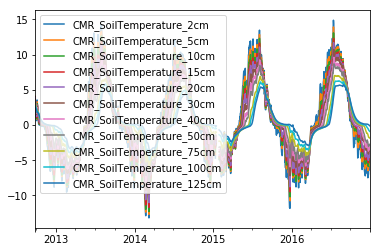

In [58]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))   ## change
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]

    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] #                     

df = threC(df,'SoilTemperature')
SoilTemperature = copy.deepcopy(df)
SoilTemperature.plot()
SoilTemperature.head(2)

In [59]:
# Put all the tables to the same date format
# data_soil.index= pd.to_datetime(data_soil.index, format= '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S') #%-H:%M:%S
# data.index= pd.to_datetime(data.index, format= '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S') #%-H:%M:%S
# data_lwr.index= pd.to_datetime(data_lwr.index, format= '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S') #%-H:%M:%S

# Bring them together
result1 = pd.concat([Discharge,Precipitation,AirTemperature,SolarRadiation,RelativeHumidity,WindDirection,WindSpeed,
                     SnowDepth,SoilMoisture,SoilTemperature],axis=1,
                    join='outer')


In [60]:
result1.index=pd.to_datetime(result1.index)
result1.sort_index(inplace=True)

In [61]:
result1.head(5)

Dwnstr_Discharge  Upstr_Discharge  CMR_Precipitation  \
2012-09-26               NaN              NaN                0.0   
2012-09-27               NaN              NaN                0.0   
2012-09-28               NaN              NaN                0.0   
2012-09-29               NaN              NaN                0.0   
2012-09-30               NaN              NaN                0.0   

            CMR_AirTemperature_1m  CMR_AirTemperature_2m  CMR_SolarRadiation  \
2012-09-26               4.402000               4.799000                 NaN   
2012-09-27               3.702500               3.806250                 NaN   
2012-09-28               3.887917               4.010417                 NaN   
2012-09-29               1.569583               1.656250                 NaN   
2012-09-30              -3.887917              -3.833333                 NaN   

            CMR_RelativeHumidity_1m  CMR_RelativeHumidity_2m  \
2012-09-26                47.246000                45.355000   
2012-09-27                54.348750                53.600833   
2012-09-28                61.113750                60.063333   
2012-09-29                61.483333                60.847917   
2012-09-30                94.012500                93.731250   

            CMR_WindDirection  CMR_WindSpeed  ...  CMR_SoilTemperature_5cm  \
2012-09-26         188.730000       2.531000  ...                 4.068300   
2012-09-27         187.329167      10.130000  ...                 2.844875   
2012-09-28         175.283333       7.510417  ...                 2.517208   
2012-09-29         159.828750       7.041250  ...                 2.198292   
2012-09-30         205.922083       0.950833  ...                 1.632375   

            CMR_SoilTemperature_10cm  CMR_SoilTemperature_15cm  \
2012-09-26                  4.042000                  3.990300   
2012-09-27                  2.878958                  3.031125   
2012-09-28                  2.517750                  2.643750   
2012-09-29                  2.249625                  2.423750   
2012-09-30                  1.703875                  1.926000   

            CMR_SoilTemperature_20cm  CMR_SoilTemperature_30cm  \
2012-09-26                  3.930800                  3.668900   
2012-09-27                  3.146417                  3.291375   
2012-09-28                  2.749875                  2.918208   
2012-09-29                  2.547458                  2.730958   
2012-09-30                  2.096417                  2.383667   

            CMR_SoilTemperature_40cm  CMR_SoilTemperature_50cm  \
2012-09-26                  3.399500                  3.250000   
2012-09-27                  3.254500                  3.209875   
2012-09-28                  2.931708                  2.949083   
2012-09-29                  2.747625                  2.767833   
2012-09-30                  2.484375                  2.557958   

            CMR_SoilTemperature_75cm  CMR_SoilTemperature_100cm  \
2012-09-26                  3.050300                   2.792800   
2012-09-27                  2.974083                   2.725750   
2012-09-28                  2.843542                   2.650667   
2012-09-29                  2.715500                   2.564125   
2012-09-30                  2.590000                   2.474458   

            CMR_SoilTemperature_125cm  
2012-09-26                   2.514700  
2012-09-27                   2.459500  
2012-09-28                   2.419583  
2012-09-29                   2.370042  
2012-09-30                   2.308500  

[5 rows x 25 columns]

In [62]:
result1.index.rename('DateTime', inplace = True)
result1.to_csv('1_NorthernGulfofAlaska_Download_Aggregation_Daily.csv', sep=',')